# Implicit Pairwise Loss Functions
> Learn about bpr, hinge, and warp losses and their adpative versions. Also learning partial credit adjustment in losses.

- toc: true
- badges: true
- comments: true
- categories: [PyTorch, LossFunction, Evaluation, Implicit]
- image:

In its simplest form, each loss function accepts as input a prediction score for a positive item (an item a user has interacted with), and a prediction score for a negative item (an item a user has not interacted with). While the mathematical details differ between each loss, generally, all implicit losses will punish a model for ranking a negative item higher than a positive item. The severity of this punishment differs across loss functions. Two standard loss functions are Bayesian Personalized Ranking (BPR) loss and Hinge loss.

Some losses extend this idea by being “adaptive,” or accepting multiple negative item prediction scores for each positive score. These losses are typically much more punishing than “non-adaptive” losses, since they allow more opportunities for the model to incorrectly rank a negative item higher than a positive one. These losses include Adaptive Bayesian Personalized Ranking loss, Adaptive Hinge loss, and Weighted Approximately Ranked Pairwise (WARP) loss.

In [13]:
from typing import Any, Dict, Optional, Union
import torch

### BPR Loss Function

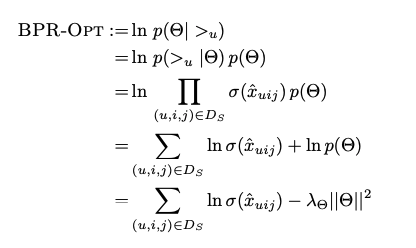

In [15]:
def bpr_loss(
    positive_scores: torch.tensor,
    negative_scores: torch.tensor,
    num_items: Optional[Any] = None,
    positive_items: Optional[torch.tensor] = None,
    negative_items: Optional[torch.tensor] = None,
    metadata: Optional[Dict[str, torch.tensor]] = dict(),
    metadata_weights: Optional[Dict[str, float]] = dict(),
) -> torch.tensor:
    """
    Parameters
    ----------
    positive_scores: torch.tensor, 1-d
        Tensor containing predictions for known positive items of shape ``1 x batch_size``
    negative_scores: torch.tensor, 1-d
        Tensor containing scores for a single sampled negative item of shape ``1 x batch_size``
    num_items: Any
        Ignored, included only for compatability with WARP loss
    positive_items: torch.tensor, 1-d
        Tensor containing ids for known positive items of shape ``1 x batch_size``. This is only
        needed if ``metadata`` is provided
    negative_items: torch.tensor, 1-d
        Tensor containing ids for randomly-sampled negative items of shape ``1 x batch_size``. This
        is only needed if ``metadata`` is provided
    metadata: dict
        Keys should be strings identifying each metadata type that match keys in
        ``metadata_weights``. Values should be a ``torch.tensor`` of shape (num_items x 1). Each
        tensor should contain categorical metadata information about items (e.g. a number
        representing the genre of the item)
    metadata_weights: dict
        Keys should be strings identifying each metadata type that match keys in ``metadata``.
        Values should be the amount of weight to place on a match of that type of metadata, with the
        sum of all values ``<= 1``.
        e.g. If ``metadata_weights = {'genre': .3, 'director': .2}``, then an item is:

        * a 100% match if it's the same item,

        * a 50% match if it's a different item with the same genre and same director,

        * a 30% match if it's a different item with the same genre and different director,

        * a 20% match if it's a different item with a different genre and same director,

        * a 0% match if it's a different item with a different genre and different director,
          which is equivalent to the loss without any partial credit

    Returns
    -------
    loss: torch.tensor

    References
    ----------
    .. [1] Hildesheim et al. "BPR: Bayesian Personalized Ranking from Implicit Feedback." BPR |
        Proceedings of the Twenty-Fifth Conference on Uncertainty in Artificial Intelligence, 1 June
        2009, dl.acm.org/doi/10.5555/1795114.1795167.

    """
    preds = positive_scores - negative_scores

    if metadata is not None and len(metadata) > 0:
        ideal_difference = ideal_difference_from_metadata(
            positive_items=positive_items,
            negative_items=negative_items,
            metadata=metadata,
            metadata_weights=metadata_weights,
        )
    else:
        ideal_difference = 1

    loss = (ideal_difference - torch.sigmoid(preds))

    return (loss.sum() + loss.pow(2).sum()) / len(positive_scores)

### Adaptive BPR Loss Function

In [16]:
def adaptive_bpr_loss(
    positive_scores: torch.tensor,
    many_negative_scores: torch.tensor,
    num_items: Optional[Any] = None,
    positive_items: Optional[torch.tensor] = None,
    negative_items: Optional[torch.tensor] = None,
    metadata: Optional[Dict[str, torch.tensor]] = dict(),
    metadata_weights: Optional[Dict[str, float]] = dict(),
) -> torch.tensor:
    """
    Parameters
    ----------
    positive_scores: torch.tensor, 1-d
        Tensor containing scores for known positive items of shape
        ``num_negative_samples x batch_size``
    many_negative_scores: torch.tensor, 2-d
        Iterable of tensors containing scores for many (n > 1) sampled negative items of shape
        ``num_negative_samples x batch_size``. More tensors increase the likelihood of finding
        ranking-violating pairs, but risk overfitting
    num_items: Any
        Ignored, included only for compatability with WARP loss
    positive_items: torch.tensor, 1-d
        Tensor containing ids for known positive items of shape
        ``num_negative_samples x batch_size``. This is only needed if ``metadata`` is provided
    negative_items: torch.tensor, 2-d
        Tensor containing ids for sampled negative items of shape
        ``num_negative_samples x batch_size``. This is only needed if ``metadata`` is provided
    metadata: dict
        Keys should be strings identifying each metadata type that match keys in
        ``metadata_weights``. Values should be a ``torch.tensor`` of shape (num_items x 1). Each
        tensor should contain categorical metadata information about items (e.g. a number
        representing the genre of the item)
    metadata_weights: dict
        Keys should be strings identifying each metadata type that match keys in ``metadata``.
        Values should be the amount of weight to place on a match of that type of metadata, with the
        sum of all values ``<= 1``.
        e.g. If ``metadata_weights = {'genre': .3, 'director': .2}``, then an item is:

        * a 100% match if it's the same item,

        * a 50% match if it's a different item with the same genre and same director,

        * a 30% match if it's a different item with the same genre and different director,

        * a 20% match if it's a different item with a different genre and same director,

        * a 0% match if it's a different item with a different genre and different director,
          which is equivalent to the loss without any partial credit

    Returns
    -------
    loss: torch.tensor

    """
    highest_negative_scores, highest_negative_inds = torch.max(many_negative_scores, 0)

    if negative_items is not None and positive_items is not None:
        negative_items = (
            negative_items[highest_negative_inds, torch.arange(len(positive_items))].squeeze()
        )

    return bpr_loss(
        positive_scores,
        highest_negative_scores.squeeze(),
        positive_items=positive_items,
        negative_items=negative_items,
        metadata=metadata,
        metadata_weights=metadata_weights,
    )

### Hinge Loss Function

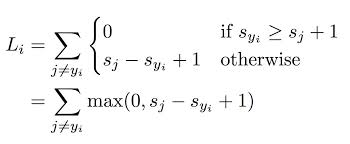

In [17]:
def hinge_loss(
    positive_scores: torch.tensor,
    negative_scores: torch.tensor,
    num_items: Optional[Any] = None,
    positive_items: Optional[torch.tensor] = None,
    negative_items: Optional[torch.tensor] = None,
    metadata: Optional[Dict[str, torch.tensor]] = dict(),
    metadata_weights: Optional[Dict[str, float]] = dict(),
) -> torch.tensor:
    """
    Parameters
    ----------
    positive_scores: torch.tensor, 1-d
        Tensor containing scores for known positive items
    negative_scores: torch.tensor, 1-d
        Tensor containing scores for a single sampled negative item
    num_items: Any
        Ignored, included only for compatability with WARP loss
    positive_items: torch.tensor, 1-d
        Tensor containing ids for known positive items of shape ``1 x batch_size``. This is only
        needed if ``metadata`` is provided
    negative_items: torch.tensor, 1-d
        Tensor containing ids for randomly-sampled negative items of shape ``1 x batch_size``. This
        is only needed if ``metadata`` is provided
    metadata: dict
        Keys should be strings identifying each metadata type that match keys in
        ``metadata_weights``. Values should be a ``torch.tensor`` of shape (num_items x 1). Each
        tensor should contain categorical metadata information about items (e.g. a number
        representing the genre of the item)
    metadata_weights: dict
        Keys should be strings identifying each metadata type that match keys in ``metadata``.
        Values should be the amount of weight to place on a match of that type of metadata, with the
        sum of all values ``<= 1``.
        e.g. If ``metadata_weights = {'genre': .3, 'director': .2}``, then an item is:
        * a 100% match if it's the same item,
        * a 50% match if it's a different item with the same genre and same director,
        * a 30% match if it's a different item with the same genre and different director,
        * a 20% match if it's a different item with a different genre and same director,
        * a 0% match if it's a different item with a different genre and different director,
          which is equivalent to the loss without any partial credit
    Returns
    -------
    loss: torch.tensor
    References
    ----------
    .. [2] "Hinge Loss." Wikipedia, Wikimedia Foundation, 5 Mar. 2021, en.wikipedia.org/wiki/
        Hinge_loss.
    """
    score_difference = (positive_scores - negative_scores)

    if metadata is not None and len(metadata) > 0:
        ideal_difference = ideal_difference_from_metadata(
            positive_items=positive_items,
            negative_items=negative_items,
            metadata=metadata,
            metadata_weights=metadata_weights,
        )
    else:
        ideal_difference = 1

    loss = torch.clamp((ideal_difference - score_difference), min=0)

    return (loss.sum() + loss.pow(2).sum()) / len(positive_scores)

### Adaptive Hinge Loss Function

In [18]:
def adaptive_hinge_loss(
    positive_scores: torch.tensor,
    many_negative_scores: torch.tensor,
    num_items: Optional[Any] = None,
    positive_items: Optional[torch.tensor] = None,
    negative_items: Optional[torch.tensor] = None,
    metadata: Optional[Dict[str, torch.tensor]] = dict(),
    metadata_weights: Optional[Dict[str, float]] = dict(),
) -> torch.tensor:
    """
    Parameters
    ----------
    positive_scores: torch.tensor, 1-d
        Tensor containing scores for known positive items of shape
        ``num_negative_samples x batch_size``
    many_negative_scores: torch.tensor, 2-d
        Iterable of tensors containing scores for many (n > 1) sampled negative items of shape
        ``num_negative_samples x batch_size``. More tensors increase the likelihood of finding
        ranking-violating pairs, but risk overfitting
    num_items: Any
        Ignored, included only for compatability with WARP loss
    positive_items: torch.tensor, 1-d
        Tensor containing ids for known positive items of shape
        ``num_negative_samples x batch_size``. This is only needed if ``metadata`` is provided
    negative_items: torch.tensor, 2-d
        Tensor containing ids for sampled negative items of shape
        ``num_negative_samples x batch_size``. This is only needed if ``metadata`` is provided
    metadata: dict
        Keys should be strings identifying each metadata type that match keys in
        ``metadata_weights``. Values should be a ``torch.tensor`` of shape (num_items x 1). Each
        tensor should contain categorical metadata information about items (e.g. a number
        representing the genre of the item)
    metadata_weights: dict
        Keys should be strings identifying each metadata type that match keys in ``metadata``.
        Values should be the amount of weight to place on a match of that type of metadata, with the
        sum of all values ``<= 1``.
        e.g. If ``metadata_weights = {'genre': .3, 'director': .2}``, then an item is:
        * a 100% match if it's the same item,
        * a 50% match if it's a different item with the same genre and same director,
        * a 30% match if it's a different item with the same genre and different director,
        * a 20% match if it's a different item with a different genre and same director,
        * a 0% match if it's a different item with a different genre and different director,
          which is equivalent to the loss without any partial credit
    Returns
    -------
    loss: torch.tensor
    References
    ----------
    .. [3] Kula, Maciej. "Loss Functions." Loss Functions - Spotlight Documentation,
        maciejkula.github.io/spotlight/losses.html.
    """
    highest_negative_scores, highest_negative_inds = torch.max(many_negative_scores, 0)

    if negative_items is not None and positive_items is not None:
        negative_items = (
            negative_items[highest_negative_inds, torch.arange(len(positive_items))].squeeze()
        )

    return hinge_loss(
        positive_scores,
        highest_negative_scores.squeeze(),
        positive_items=positive_items,
        negative_items=negative_items,
        metadata=metadata,
        metadata_weights=metadata_weights,
    )

In [19]:
def _find_first_loss_violation(losses: torch.tensor,
                               device: Union[str, torch.device, torch.cuda.device]) -> torch.tensor:
    """
    Find the index of the first violation where ``1 - positive_score + negative_score`` is greater
    than 0.
    """
    # set all negative losses to 0 and all positive losses to 1
    losses[losses < 0] = 0
    losses[losses > 0] = 1

    # after this, maximum value will be the first non-zero (bad) loss
    reverse_indices = torch.arange(losses.shape[1], 0, -1).to(device)
    min_index_of_good_loss = losses * reverse_indices

    # report the first loss that is positive here (not 0-based indexed)
    number_of_tries = torch.argmax(min_index_of_good_loss, 1, keepdim=True).flatten()

    return number_of_tries

### WARP Loss Function

In [20]:
def warp_loss(
    positive_scores: torch.tensor,
    many_negative_scores: torch.tensor,
    num_items: int,
    positive_items: Optional[torch.tensor] = None,
    negative_items: Optional[torch.tensor] = None,
    metadata: Optional[Dict[str, torch.tensor]] = dict(),
    metadata_weights: Optional[Dict[str, float]] = dict(),
) -> torch.tensor:
    """
    Parameters
    ----------
    positive_scores: torch.tensor, 1-d
        Tensor containing scores for known positive items of shape
        ``num_negative_samples x batch_size``
    many_negative_scores: torch.tensor, 2-d
        Iterable of tensors containing scores for many (n > 1) sampled negative items of shape
        ``num_negative_samples x batch_size``. More tensors increase the likelihood of finding
        ranking-violating pairs, but risk overfitting
    num_items: int
        Total number of items in the dataset
    positive_items: torch.tensor, 1-d
        Tensor containing ids for known positive items of shape
        ``num_negative_samples x batch_size``. This is only needed if ``metadata`` is provided
    negative_items: torch.tensor, 2-d
        Tensor containing ids for sampled negative items of shape
        ``num_negative_samples x batch_size``. This is only needed if ``metadata`` is provided
    metadata: dict
        Keys should be strings identifying each metadata type that match keys in
        ``metadata_weights``. Values should be a ``torch.tensor`` of shape (num_items x 1). Each
        tensor should contain categorical metadata information about items (e.g. a number
        representing the genre of the item)
    metadata_weights: dict
        Keys should be strings identifying each metadata type that match keys in ``metadata``.
        Values should be the amount of weight to place on a match of that type of metadata, with the
        sum of all values ``<= 1``.
        e.g. If ``metadata_weights = {'genre': .3, 'director': .2}``, then an item is:
        * a 100% match if it's the same item,
        * a 50% match if it's a different item with the same genre and same director,
        * a 30% match if it's a different item with the same genre and different director,
        * a 20% match if it's a different item with a different genre and same director,
        * a 0% match if it's a different item with a different genre and different director,
          which is equivalent to the loss without any partial credit
    Returns
    -------
    loss: torch.tensor
    References
    ----------
    .. [4] Weston et al. WSABIE: Scaling Up To Large Vocabulary Image Annotation.
        www.thespermwhale.com/jaseweston/papers/wsabie-ijcai.pdf.
    """
    if negative_items is not None and positive_items is not None:
        positive_items = positive_items.repeat([many_negative_scores.shape[0], 1])

    if metadata is not None and len(metadata) > 0:
        ideal_difference = ideal_difference_from_metadata(
            positive_items=positive_items,
            negative_items=negative_items,
            metadata=metadata,
            metadata_weights=metadata_weights,
        ).transpose(1, 0)
    else:
        ideal_difference = 1

    # device to put new tensors on
    device = positive_scores.device

    # WARP loss requires a different structure for positive and negative samples
    positive_scores = positive_scores.view(len(positive_scores), 1)
    many_negative_scores = torch.transpose(many_negative_scores, 0, 1)

    batch_size, max_trials = many_negative_scores.size(0), many_negative_scores.size(1)

    flattened_new_row_indices = torch.arange(0, batch_size, 1).long().to(device) * (max_trials + 1)
    tensor_of_ones = torch.ones(batch_size, 1).float().to(device)

    # ``initial_loss`` is essentially just hinge loss for now
    hinge_loss = ideal_difference - positive_scores + many_negative_scores

    # Add column of ones to so we know when we have used all our attempts. This is used for indexing
    # and computing ``should_count_loss`` if no real value is above 0.
    initial_loss_with_ones = torch.cat([hinge_loss, tensor_of_ones], dim=1)
    # this will be modified in ``_find_first_loss_violation``
    initial_loss_with_ones_binary = torch.cat([hinge_loss, tensor_of_ones], dim=1)

    number_of_tries = _find_first_loss_violation(initial_loss_with_ones_binary, device)

    prediction_index_for_flattened_predictions = number_of_tries + flattened_new_row_indices

    number_of_tries = (number_of_tries + 1).float()

    # IMPORTANT CHANGE: normal WARP weighting has the numerator set to ``num_items - 1``, but we
    # have found this does not penalize when the last item in a negative item sequence ranks above a
    # positive item score. Adjusting the numerator as below penalizes this correctly. Additionally,
    # adding a floor function to the numerator can also have the same negative effect of not
    # not counting loss. See the original implementation as a comment below, and our modified,
    # harsher calculation implemented below.
    # loss_weights = torch.log(torch.floor((num_items - 1) / number_of_tries))
    loss_weights = torch.log((num_items / number_of_tries))

    # don't count loss if we used max number of attempts looking for a violation and didn't find one
    should_we_count_loss = (number_of_tries <= max_trials).float()

    loss = (
        loss_weights
        * (
            initial_loss_with_ones.flatten()[prediction_index_for_flattened_predictions]
        )
        * should_we_count_loss
    )

    return (loss.sum() + loss.pow(2).sum()) / len(positive_scores)

### Partial Credit Function

Helper function to calculate the ideal score difference between the positive and negative items. Without considering metadata, the ideal score difference would be 1.0 (since the function looks at a pair of items, one positive item and one negative item). Taking metadata into consideration, the ideal score difference should be between 0 and 1 if there is a partial match (not the same item, but matching metadata - e.g. the same film genre).

This function calculates that ideal difference when there is metadata available. Metadata passed in to this function is independent of metadata given to the model during training - it can be the same data or a different set. For example, one might use genre embeddings as metadata during training and use genre labels as metadata during loss calculation (since all metadata passed in to this function must be categorical).

In [ ]:
def ideal_difference_from_metadata(
    positive_items: torch.tensor,
    negative_items: torch.tensor,
    metadata: Optional[Dict[str, torch.tensor]],
    metadata_weights: Optional[Dict[str, float]],
) -> torch.tensor:
    """
    Parameters
    ----------
    positive_items: torch.tensor, 1-d
        Tensor containing IDs for known positive items
    negative_items: torch.tensor, 1-d
        Tensor containing IDs for sampled negative items
    metadata: dict
        Keys should be strings identifying each metadata type that match keys in
        ``metadata_weights``. Values should be a ``torch.tensor`` of shape (num_items x 1). Each
        tensor should contain categorical metadata information about items (e.g. a number
        representing the genre of the item)
    metadata_weights: dict
        Keys should be strings identifying each metadata type that match keys in ``metadata``.
        Values should be the amount of weight to place on a match of that type of metadata, with the
        sum of all values ``<= 1``.
        e.g. If ``metadata_weights = {'genre': .3, 'director': .2}``, then an item is:
        * a 100% match if it's the same item,
        * a 50% match if it's a different item with the same genre and same director,
        * a 30% match if it's a different item with the same genre and different director,
        * a 20% match if it's a different item with a different genre and same director,
        * a 0% match if it's a different item with a different genre and different director,
          which is equivalent to the loss without any partial credit
    Returns
    -------
    ideal difference: torch.tensor
        Tensor with the same shape as ``positive_items``, with each element between 0 and 1
    """
    weight_sum = sum(metadata_weights.values())
    if weight_sum > 1:
        raise ValueError(f'sum of metadata weights was {weight_sum}, must be <=1')

    match_frac = torch.zeros(positive_items.shape).to(positive_items.device)
    for k, array in metadata.items():
        array = array.squeeze()
        match_frac += (
            array[positive_items.long()] == array[negative_items.long()]
        ).int().to(positive_items.device)*metadata_weights[k]

    return 1.0 - match_frac

## Examples

### Standard Implicit Loss Functions

In [12]:
# an ideal loss case
positive_score = torch.tensor([3.0])
negative_score = torch.tensor([1.5])

print('BPR Loss:  ', bpr_loss(positive_score, negative_score))
print('Hinge Loss:', hinge_loss(positive_score, negative_score))

print('\n-----\n')

# a less-than-ideal loss case
positive_score = torch.tensor([1.5])
negative_score = torch.tensor([3.0])

print('BPR Loss:  ', bpr_loss(positive_score, negative_score))
print('Hinge Loss:', hinge_loss(positive_score, negative_score))

BPR Loss:   tensor(0.2157)
Hinge Loss: tensor(0.)

-----

BPR Loss:   tensor(1.4860)
Hinge Loss: tensor(8.7500)


### Adaptive Implicit Loss Functions

In [21]:
# an ideal loss case
positive_score = torch.tensor([3.0])
many_negative_scores = torch.tensor([[1.5], [0.5], [1.0]])

print('Adaptive BPR Loss:  ', adaptive_bpr_loss(positive_score, many_negative_scores))
print('Adaptive Hinge Loss:', adaptive_hinge_loss(positive_score, many_negative_scores))
print('WARP Loss:          ', warp_loss(positive_score, many_negative_scores, num_items=3))

print('\n-----\n')

# a less-than-ideal loss case
positive_score = torch.tensor([1.5])
many_negative_scores = torch.tensor([[2.0], [3.0], [2.5]])

print('Adaptive BPR Loss:  ', adaptive_bpr_loss(positive_score, many_negative_scores))
print('Adaptive Hinge Loss:', adaptive_hinge_loss(positive_score, many_negative_scores))
print('WARP Loss:          ', warp_loss(positive_score, many_negative_scores, num_items=3))
print('WARP Loss:          ', warp_loss(positive_score, many_negative_scores, num_items=30))

print('\n-----\n')

# a case where multiple negative items gives us greater opportunity to correct the model
positive_score = torch.tensor([1.5])
many_negative_scores = torch.tensor([[1.0], [4.0], [1.49]])

print('Adaptive BPR Loss:  ', adaptive_bpr_loss(positive_score, many_negative_scores))
print('Adaptive Hinge Loss:', adaptive_hinge_loss(positive_score, many_negative_scores))
print('WARP Loss:          ', warp_loss(positive_score, many_negative_scores, num_items=3))
print('WARP Loss:          ', warp_loss(positive_score, many_negative_scores, num_items=30))

Adaptive BPR Loss:   tensor(0.2157)
Adaptive Hinge Loss: tensor(0.)
WARP Loss:           tensor(0.)

-----

Adaptive BPR Loss:   tensor(1.4860)
Adaptive Hinge Loss: tensor(8.7500)
WARP Loss:           tensor(4.3636)
WARP Loss:           tensor(31.1301)

-----

Adaptive BPR Loss:   tensor(1.7782)
Adaptive Hinge Loss: tensor(15.7500)
WARP Loss:           tensor(0.8510)
WARP Loss:           tensor(4.5926)


### Partial Credit Loss Functions

If you have item metadata available, you might reason that not all losses should be equal. For example, say you are training a recommendation system on MovieLens data, where users interact with different films, and you are comparing a positive item, Star Wars, with two negative items: Star Trek and Legally Blonde.

Normally, the loss for Star Wars compared with Star Trek, and Star Wars compared with Legally Blonde would be equal. But, as humans, we know that Star Trek is closer to Star Wars (both being space western films) than Legally Blonde is (a romantic comedy that does not have space elements), and would want our loss function to account for that 5.

For these scenarios, these loss functions support partial credit calculations, meaning we can provide metadata to reduce the potential loss for certain items with matching metadata.

In [22]:
# positive item is Star Wars
star_wars_score = torch.tensor([1.0])

# negative items are Star Trek and Legally Blonde
star_trek_score = torch.tensor([3.0])
legally_blonde_score = torch.tensor([3.0])

print('Star Wars vs Star Trek Loss:      ', end='')
print(bpr_loss(positive_scores=star_wars_score, negative_scores=star_trek_score))

print('Star Wars vs Legally Blonde Loss: ', end='')
print(bpr_loss(positive_scores=star_wars_score, negative_scores=legally_blonde_score))

print('\n-----\n')

# now let's apply a partial credit calculation to the loss
metadata_weights = {'genre': 0.25}

# categorically encode Sci-Fi as ``0`` and Comedy as ``1`` and
# order values by Star Wars, Star Trek, Legally Blonde
metadata = {'genre': torch.tensor([0, 0, 1])}

print('Star Wars vs Star Trek Partial Credit Loss:      ', end='')
print(bpr_loss(positive_scores=star_wars_score,
               negative_scores=star_trek_score,
               positive_items=torch.tensor([0]),
               negative_items=torch.tensor([1]),
               metadata=metadata,
               metadata_weights=metadata_weights))

print('Star Wars vs Legally Blonde Partial Credit Loss: ', end='')
print(bpr_loss(positive_scores=star_wars_score,
               negative_scores=legally_blonde_score,
               positive_items=torch.tensor([0]),
               negative_items=torch.tensor([2]),
               metadata=metadata,
               metadata_weights=metadata_weights))

Star Wars vs Star Trek Loss:      tensor(1.6566)
Star Wars vs Legally Blonde Loss: tensor(1.6566)

-----

Star Wars vs Star Trek Partial Credit Loss:      tensor(1.0287)
Star Wars vs Legally Blonde Partial Credit Loss: tensor(1.6566)


## References

- https://collie.readthedocs.io/en/latest/loss.html
- http://www.thespermwhale.com/jaseweston/papers/wsabie-ijcai.pdf
- https://github.com/maciejkula/spotlight/blob/master/spotlight/losses.py
- https://github.com/EthanRosenthal/torchmf/blob/master/torchmf.py
- https://colab.research.google.com/github/ShopRunner/collie/blob/main/tutorials/04_partial_credit_loss.ipynb